In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from PIL import Image

In [3]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
def load_images(folders, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []

    # loading the images from each folder in the dataset
    for folder in folders:
        for category in os.listdir(folder):
            category_path = os.path.join(folder, category)
            if os.path.isdir(category_path):
                if category in label_map:  # Check if the category is present in the label_map
                    label = label_map[category]
                    file_list = os.listdir(category_path)
                    for filename in file_list:
                        img_path = os.path.join(category_path, filename)
                        image = cv2.imread(img_path)
                        # resizing the images to create a standard and so that it can be suitable for the model input
                        image = cv2.resize(image, (224, 224))
                        # cv2 reads the image as BGR so we need to convert it back to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)

    return np.array(images), np.array(labels)

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_folders = [
    '/content/drive/MyDrive/Brain Tumor Detector/archive (2)',
]

# encoding the labels
label_map = {'no': 0, 'yes': 1}  # Map negative to 0 (no) and positive to 1 (yes)

images, labels = load_images(data_folders, label_map)

# Shape: (number, height, length, channel RGB)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (253, 224, 224, 3)
Shape of labels: (253,)


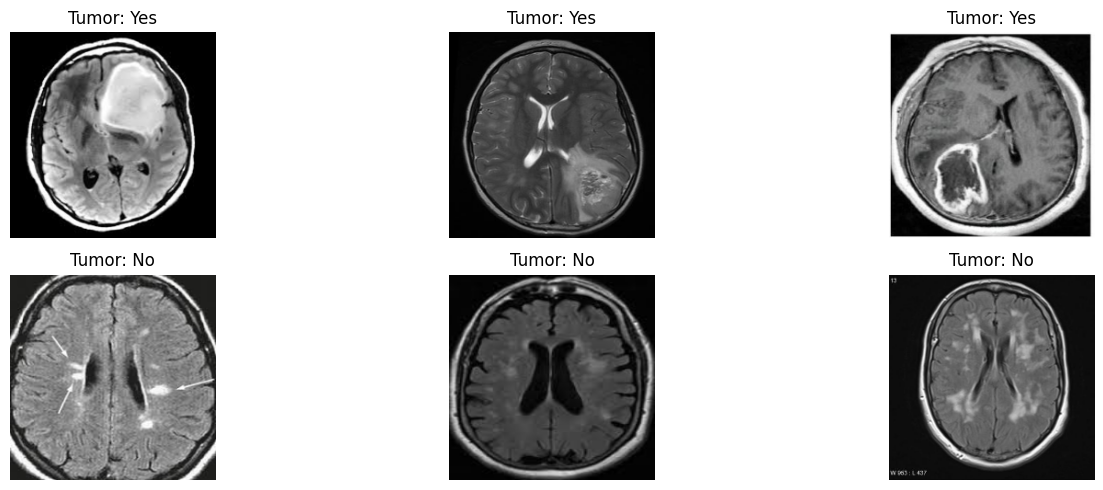

In [7]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[labels == 1][i])  # Filter images with label 'yes'
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[labels == 0][i])  # Filter images with label 'no'
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

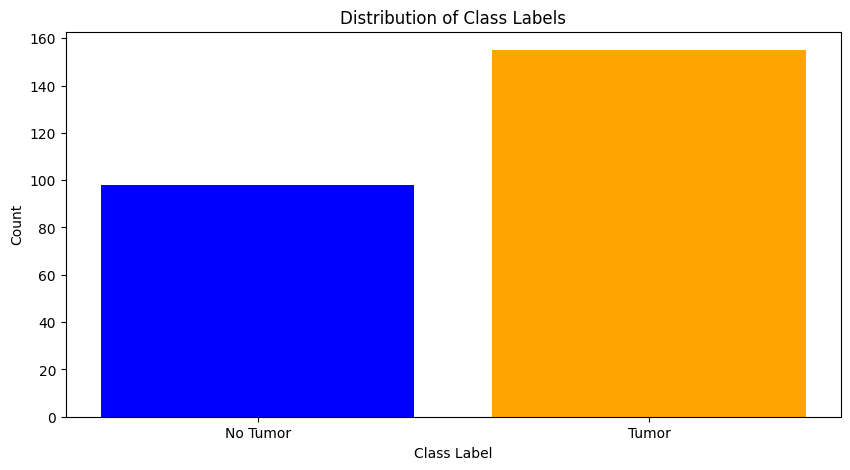

In [8]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [9]:
import keras.preprocessing.image

def crop_brain_region(image, size):

    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

     # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)

    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)

    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image



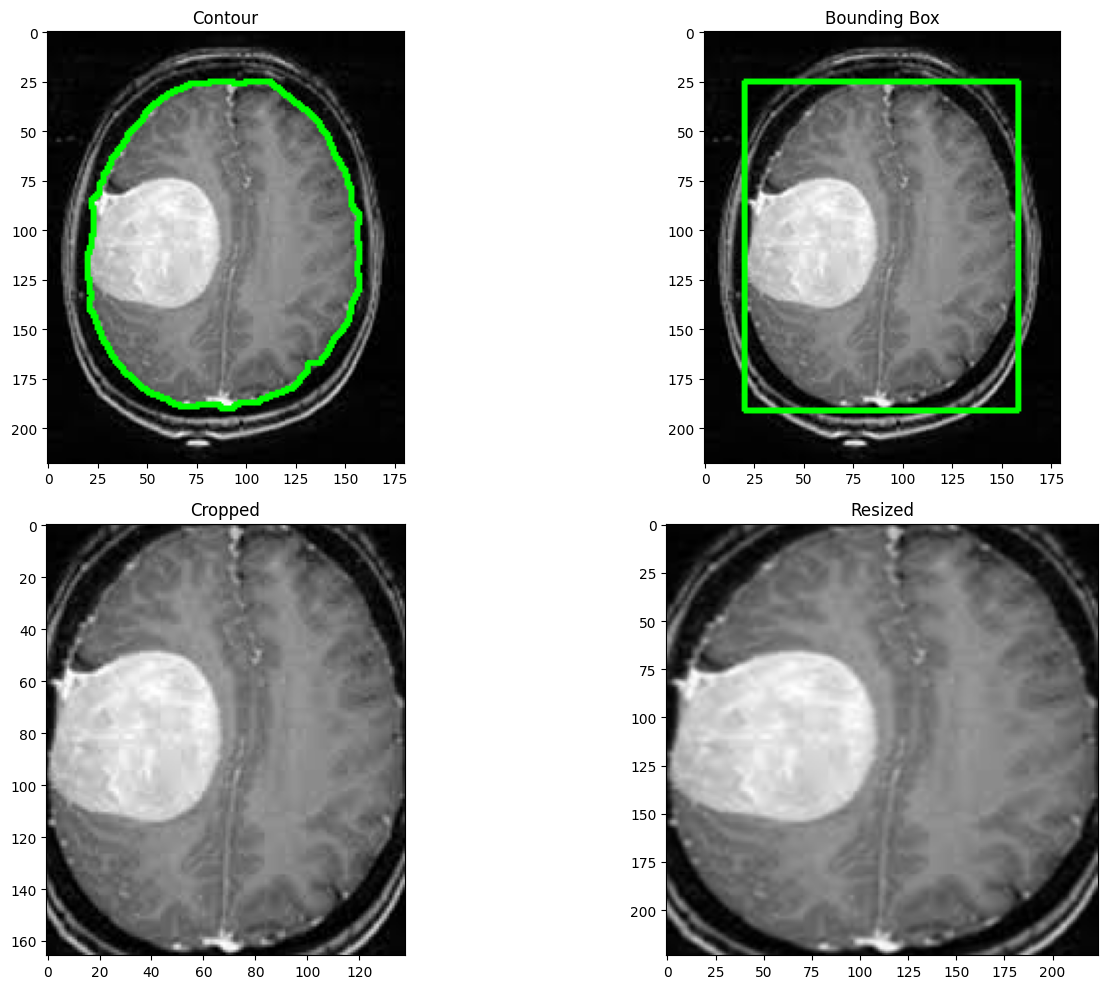

In [10]:
output_size = (224, 224)

example_image = cv2.imread('/content/drive/MyDrive/Brain Tumor Detector/archive (2)/yes/Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in images:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

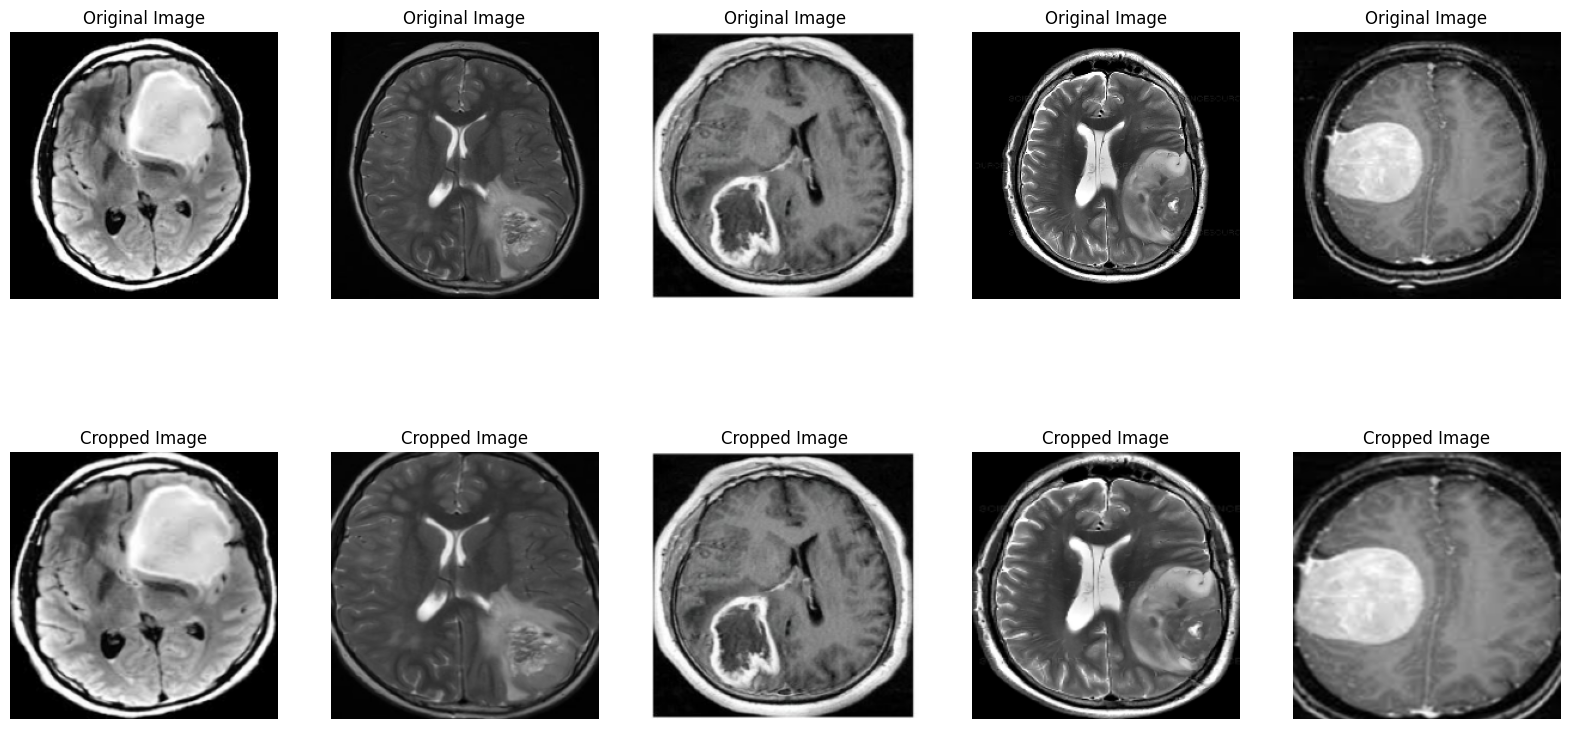

In [11]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(images[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

In [12]:
from sklearn.model_selection import train_test_split

all_cropped=np.array(all_cropped)
X_train, X_test, y_train, y_test = train_test_split(all_cropped, labels, test_size=0.2,shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (202, 224, 224, 3)
X_val shape: (25, 224, 224, 3)
X_test shape: (26, 224, 224, 3)
y_train shape: (202,)
y_val shape: (25,)
y_test shape: (26,)


In [14]:
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

label_map_decoded = {1: 'yes', 0: 'no'}

def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'  # Assuming images are in JPG format
        img_path = os.path.join(class_folder, img_filename)
        cv2.imwrite(img_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # Save image directly without converting to PIL format

In [15]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)

In [16]:
print(np.max(X_train))
print(np.min(X_train))

255
0


In [17]:
X_train_scaled=X_train/255
X_test_scaled=X_test/255
X_val_scaled=X_val/255


In [18]:
print(np.max(X_train_scaled))
print(np.min(X_train_scaled))

1.0
0.0


In [19]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam,RMSprop

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [20]:
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix

epochs = 50
batch_size = 32

# Defining early stopping to stop the model from overfitting
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

# Train the model
#history = model.fit(X_train_scaled,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val_scaled,y_val))

history = model.fit(X_train_scaled,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_scaled,y_val),
                   callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 27s 3s/step - loss: 0.6513 - accuracy: 0.6287 - val_loss: 0.7784 - val_accuracy: 0.5200
Epoch 2/50
7/7 [==============================] - 25s 4s/step - loss: 0.6613 - accuracy: 0.6337 - val_loss: 0.6894 - val_accuracy: 0.5200
Epoch 3/50
7/7 [==============================] - 24s 3s/step - loss: 0.6339 - accuracy: 0.6584 - val_loss: 0.6561 - val_accuracy: 0.5200
Epoch 4/50
7/7 [==============================] - 26s 4s/step - loss: 0.6223 - accuracy: 0.6535 - val_loss: 0.6734 - val_accuracy: 0.5200
Epoch 5/50
7/7 [==============================] - 23s 3s/step - loss: 0.5974 - accuracy: 0.6436 - val_loss: 0.6813 - val_accuracy: 0.5200
Epoch 6/50
7/7 [==============================] - 25s 4s/step - loss: 0.5891 - accuracy: 0.6634 - val_loss: 0.6128 - val_accuracy: 0.6400
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 0.5624 - accuracy: 0.6980 - val_loss: 0.5883 - val_accuracy: 0.6400
Epoch 8/50
7/7 [==================

1/1 [==============================] - 1s 847ms/step
Accuracy on Validation Set: 0.880 %


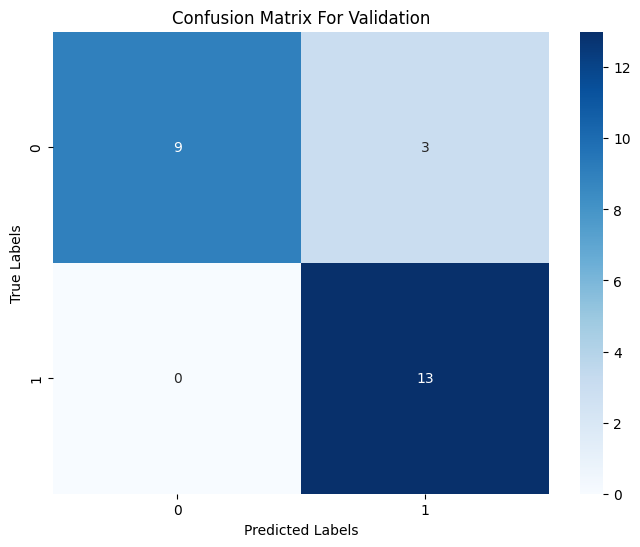

In [21]:
predictions = model.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 1s 806ms/step
Accuracy on Test Set: 0.731 %


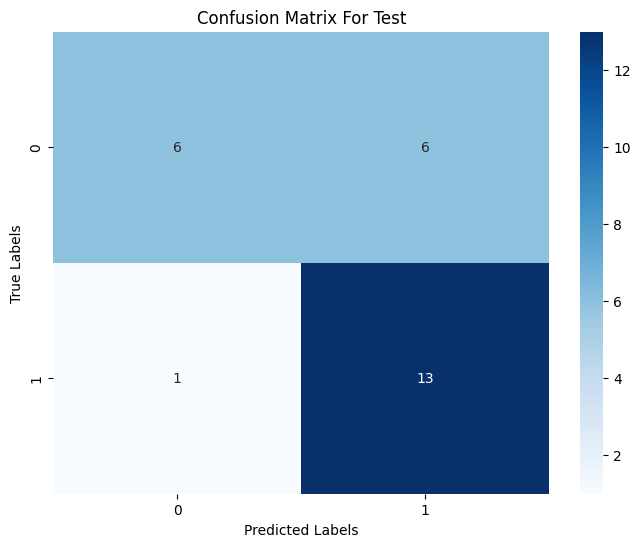

In [22]:
predictions = model.predict(X_test_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

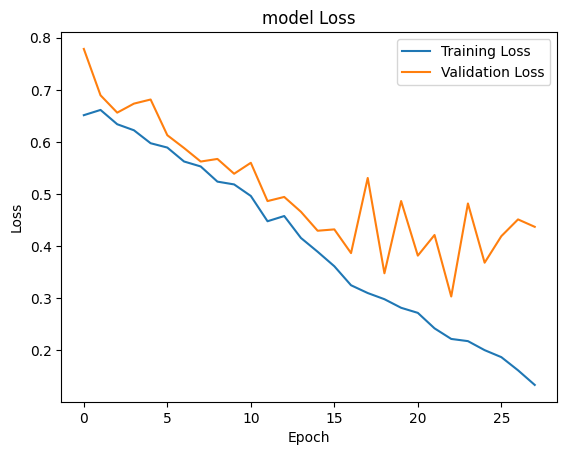

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

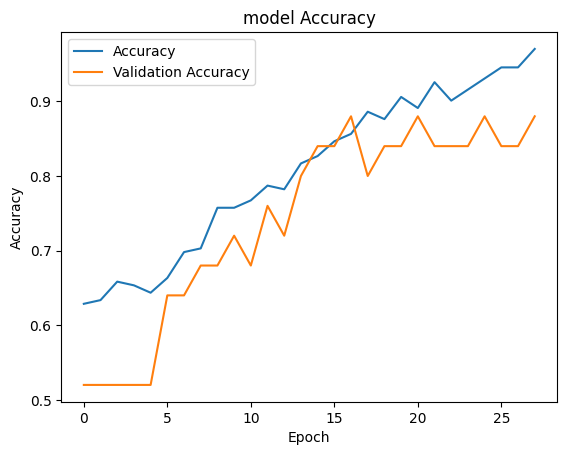

In [24]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_size=(224,224)

train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    color_mode='rgb',
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)

Found 202 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


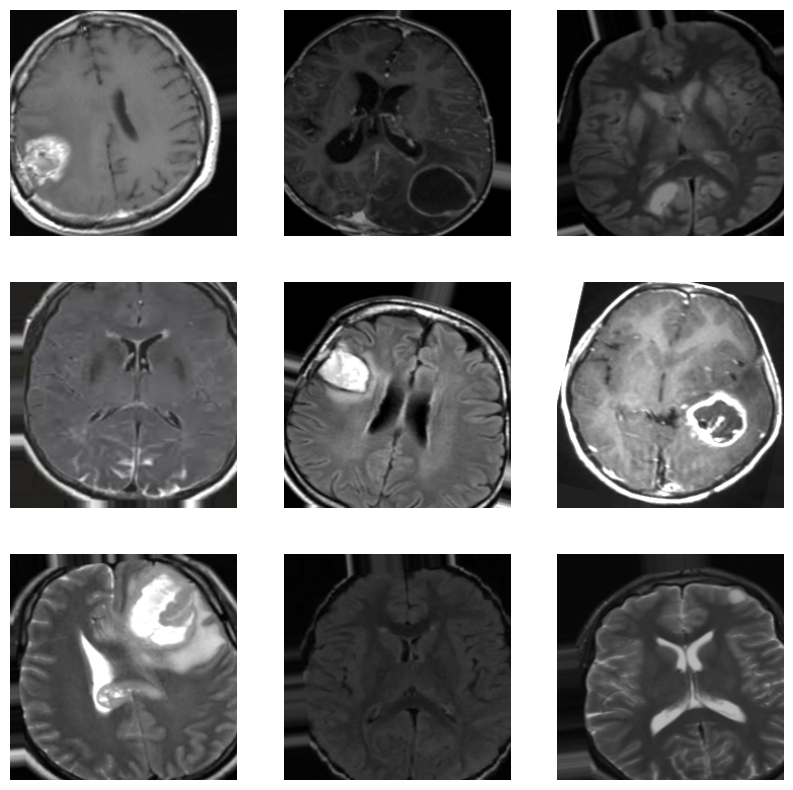

In [26]:
augmented_images, _ = next(datagen.flow(X_train, y_train, batch_size=32))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [27]:
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
from keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



base_model = VGG16(weights='/content/drive/MyDrive/Brain Tumor Detector/archive (3)/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-5]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Train the model
#history = model.fit(train_generator, epochs=50, validation_data=val_generator

Epoch 1/20
7/7 [==============================] - 179s 25s/step - loss: 0.7149 - accuracy: 0.5644 - val_loss: 0.6735 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 2/20
7/7 [==============================] - 179s 25s/step - loss: 0.6663 - accuracy: 0.6287 - val_loss: 0.6229 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 3/20
7/7 [==============================] - 172s 27s/step - loss: 0.5905 - accuracy: 0.6733 - val_loss: 0.6393 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 4/20
7/7 [==============================] - 176s 25s/step - loss: 0.5848 - accuracy: 0.6634 - val_loss: 0.8733 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 5/20
7/7 [==============================] - 182s 25s/step - loss: 0.6220 - accuracy: 0.5941 - val_loss: 0.7294 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 6/20
7/7 [==============================] - 173s 24s/step - loss: 0.4760 - accuracy: 0.7228 - val_loss: 0.6043 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 7/20
7/7 [==============================] - 175s 25s

1/1 [==============================] - 16s 16s/step
Accuracy on Validation Set: 0.880000


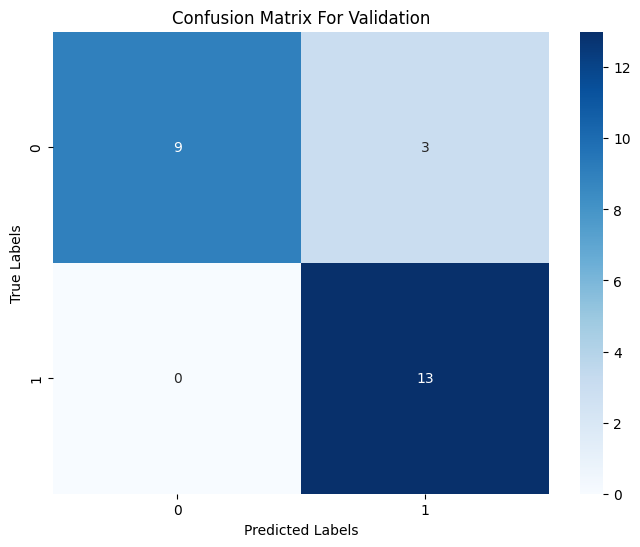

In [28]:
predictions = model.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 16s 16s/step
Accuracy on Test Set: 0.807692


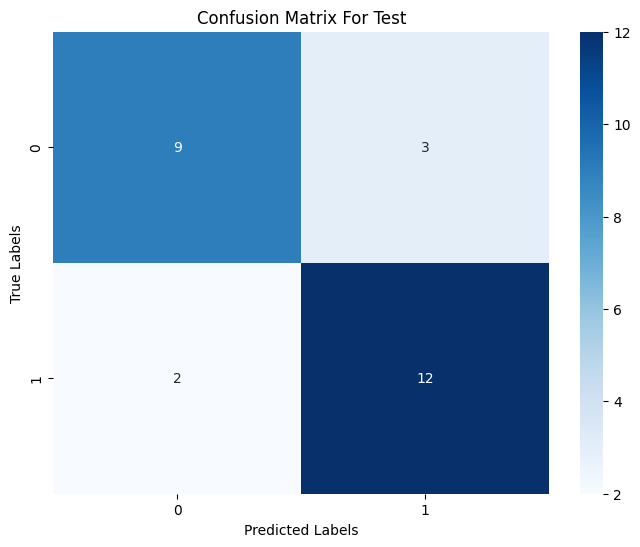

In [29]:
predictions = model.predict(X_test_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

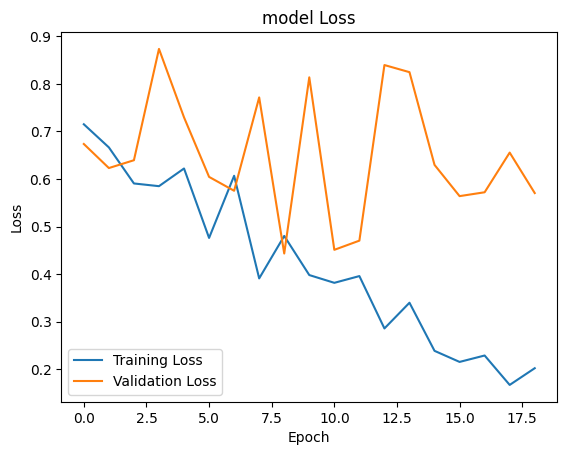

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

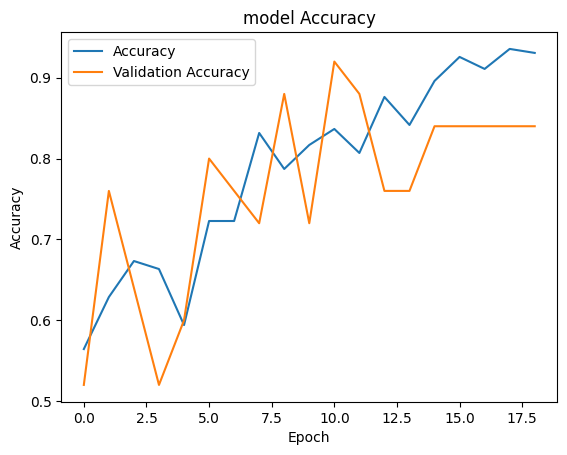

In [31]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:00


In [33]:
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import regularizers

base_model_1 = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_model_1.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model_1.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=base_model_1.input, outputs=predictions)

model_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

258076736/258076736 [==============================] - 3s 0us/step


In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model_1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
7/7 [==============================] - 190s 21s/step - loss: 0.7519 - accuracy: 0.5446 - val_loss: 0.6870 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 2/20
7/7 [==============================] - 137s 20s/step - loss: 0.7900 - accuracy: 0.4950 - val_loss: 0.6872 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 3/20
7/7 [==============================] - 141s 20s/step - loss: 0.8213 - accuracy: 0.5050 - val_loss: 0.6841 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 4/20
7/7 [==============================] - 135s 21s/step - loss: 0.7585 - accuracy: 0.5099 - val_loss: 0.6832 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 5/20
7/7 [==============================] - 142s 20s/step - loss: 0.7430 - accuracy: 0.5050 - val_loss: 0.6819 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 6/20
7/7 [==============================] - 137s 19s/step - loss: 0.8360 - accuracy: 0.5149 - val_loss: 0.6845 - val_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 7/20
7/7 [==============================] - 135s 19s

In [35]:
predictions = model_1.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

1/1 [==============================] - 22s 22s/step
Accuracy on Validation Set: 0.520000


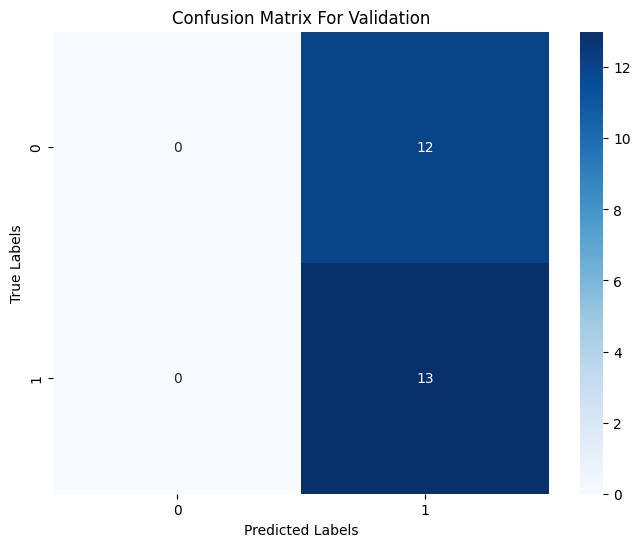

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

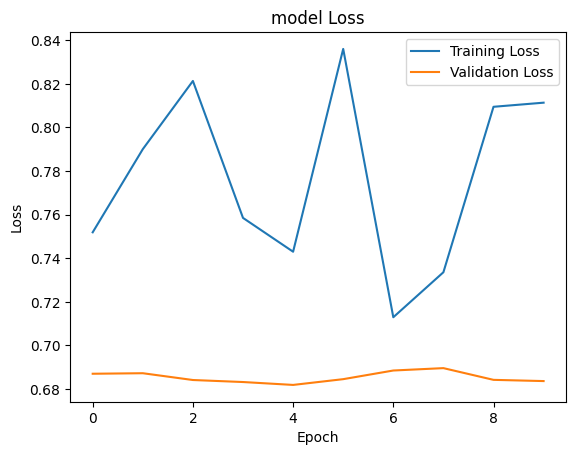

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

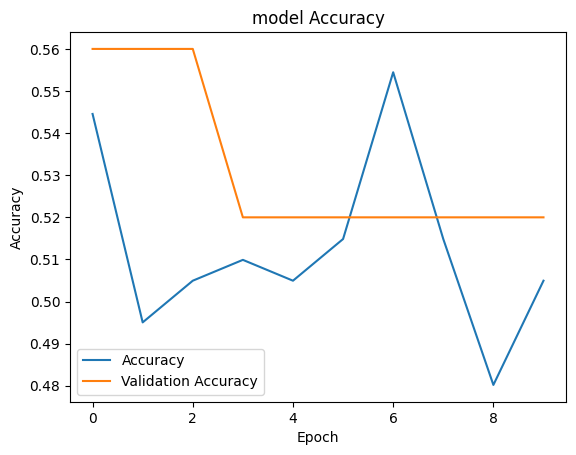

In [38]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications import Xception
from tensorflow.keras import regularizers


base_model_2 = Xception(weights='/content/drive/MyDrive/Brain Tumor Detector/archive (3)/xception_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, pooling='max')

for layer in base_model_2.layers[:-5]:
    layer.trainable = False

x = base_model_2.output
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=base_model_2.input, outputs=predictions)
model_2.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [40]:
# Train the model 2
#history = model_2.fit(train_generator, epochs=50, validation_data=val_generator)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history = model_2.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
7/7 [==============================] - 67s 10s/step - loss: 0.8034 - accuracy: 0.6188 - val_loss: 0.5197 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 2/200
7/7 [==============================] - 62s 9s/step - loss: 0.5289 - accuracy: 0.7228 - val_loss: 0.4328 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 3/200
7/7 [==============================] - 61s 9s/step - loss: 0.4582 - accuracy: 0.8119 - val_loss: 0.4193 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 4/200
7/7 [==============================] - 60s 9s/step - loss: 0.3585 - accuracy: 0.8564 - val_loss: 0.4544 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 5/200
7/7 [==============================] - 62s 10s/step - loss: 0.3478 - accuracy: 0.8614 - val_loss: 0.4951 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 6/200
7/7 [==============================] - 79s 11s/step - loss: 0.2810 - accuracy: 0.8911 - val_loss: 0.6024 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 7/200
7/7 [==============================] - 60s 8s/ste

1/1 [==============================] - 8s 8s/step
Accuracy on Validation Set: 0.840000


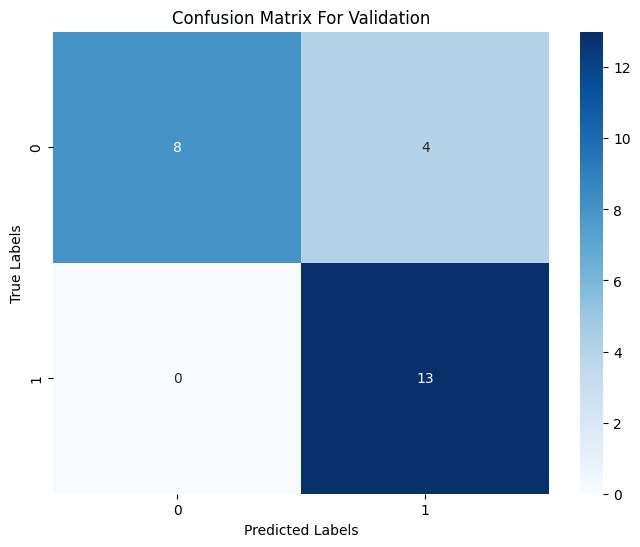

In [41]:
predictions = model_2.predict(X_val_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_val, binary_predictions)

accuracy = accuracy_score(y_val, binary_predictions)
print("Accuracy on Validation Set: {:f}".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [42]:
predictions = model_2.predict(X_test_scaled)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:f}".format(accuracy))

1/1 [==============================] - 5s 5s/step
Accuracy on Test Set: 0.730769


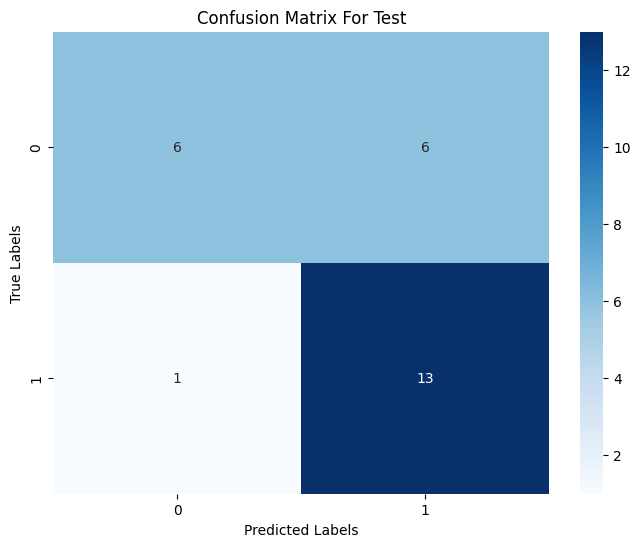

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

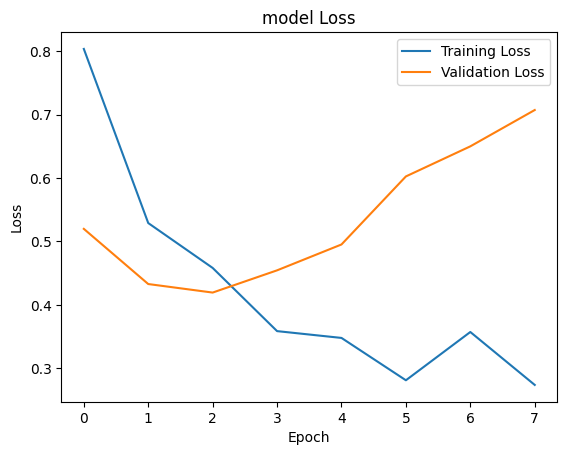

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

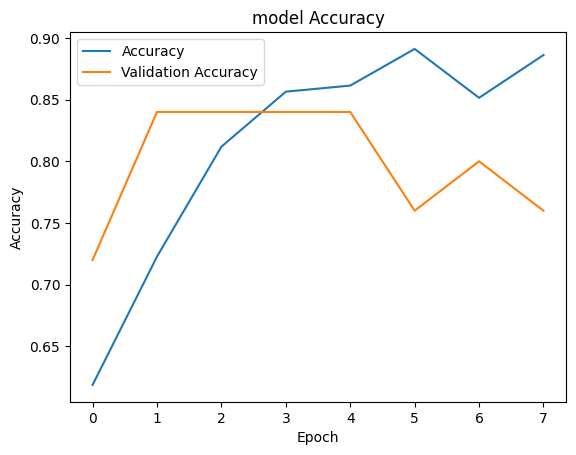

In [45]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
The MRI image is classified as: Not Tumor


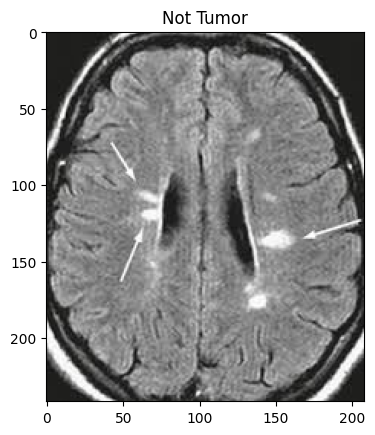

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model.save('/content/drive/MyDrive/Brain Tumor Detector')


# Load the trained model
model = load_model('/content/drive/MyDrive/Brain Tumor Detector')

# Load and preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Change target_size to the size your model expects
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the shape of the model input
    img_array /= 255.0  # Normalize the image (assuming the model was trained on normalized images)
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)

    # Assuming binary classification: 0 - 'not tumor', 1 - 'tumor'
    if prediction[0] > 0.5:
        print("The MRI image is classified as: Tumor")
    else:
        print("The MRI image is classified as: Not Tumor")

    # Plot the image
    plt.imshow(image.load_img(img_path))
    plt.title("Tumor" if prediction[0] > 0.5 else "Not Tumor")
    plt.show()

# Path to the MRI image you want to classify
img_path = '/content/drive/MyDrive/Brain Tumor Detector/0.jpg'
classify_image(img_path)
